Loading Ionosphere dataset...
Dataset info: n=200, d=34, r=35
Using m values: [ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200]
Training cross-validated SVM...
CV SVM - Loss: 0.0662, Training Time: 0.65 s
Training PAC-Bayesian aggregation for different m values...
  Processing m=10...
  Processing m=20...
  Processing m=30...
  Processing m=40...
  Processing m=50...
  Processing m=60...
  Processing m=70...
  Processing m=80...
  Processing m=90...
  Processing m=100...
  Processing m=110...
  Processing m=120...
  Processing m=130...
  Processing m=140...
  Processing m=150...
  Processing m=160...
  Processing m=170...
  Processing m=180...
  Processing m=190...
  Processing m=200...


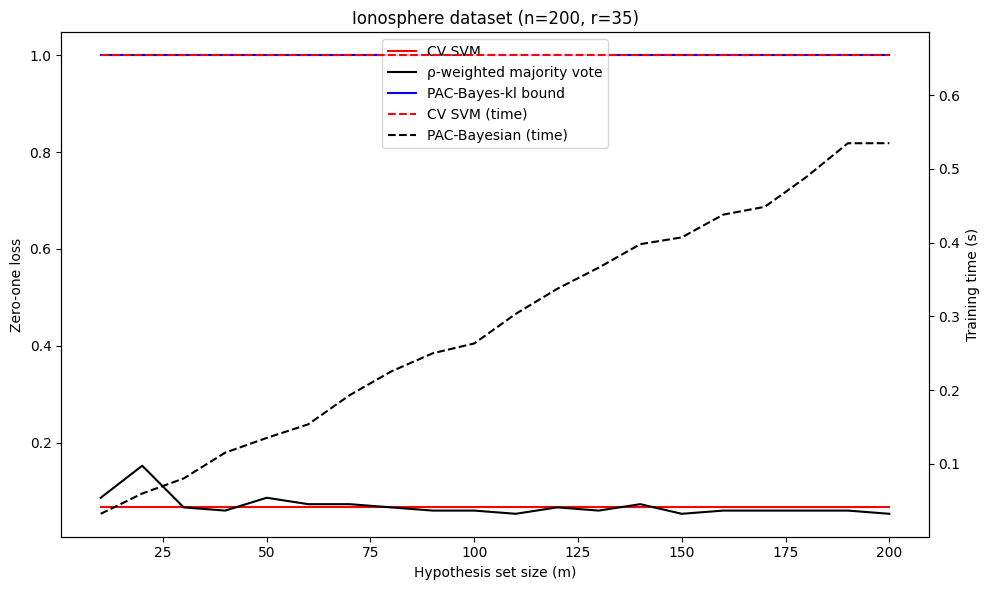

Figure saved as 'ionosphere_figure2a.png'


In [ ]:
import time
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC

# Set random seed for reproducibility
np.random.seed(42)

# 1. Load the Ionosphere dataset
print("Loading Ionosphere dataset...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
data = pd.read_csv(urllib.request.urlopen(url), header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
# Convert labels to numerical values
y = np.array([1 if label == "g" else -1 for label in y])

# Splitting the data exactly as in the paper for Ionosphere
# The paper mentions n=200, with train size of 200 and test size of 150
# We'll use the same proportions to match their setup
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=150 / 350, random_state=42
)

# Parameters
n = len(X_train)
d = X_train.shape[1]  # Feature dimension
r = d + 1  # Subsample size as specified in the paper
delta = 0.05  # Confidence parameter
print(f"Dataset info: n={n}, d={d}, r={r}")


# Binary KL divergence function (for bound computation)
def binary_kl(p, q):
    if p == 0:
        return -np.log(1 - q)
    if p == 1:
        return -np.log(q)
    return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))


# Function to invert KL for bound computation
def kl_inverse(p, epsilon, precision=1e-8):
    """Compute q such that kl(p||q) ≤ epsilon using binary search"""
    if p == 0:
        return 0
    if p == 1:
        return 1

    # Binary search for q
    q_min, q_max = p, 1.0
    q = (q_min + q_max) / 2

    while q_max - q_min > precision:
        if binary_kl(p, q) <= epsilon:
            q_max = q
        else:
            q_min = q
        q = (q_min + q_max) / 2

    return q_max


# 2. Baseline: Cross-validated SVM
def train_cv_svm(X_train, y_train, X_test, y_test):
    print("Training cross-validated SVM...")
    start_time = time.time()

    # Jaakkola's heuristic for gamma values
    distances = []
    for i in range(min(100, len(X_train))):  # Sample for efficiency
        diff_class_indices = np.where(y_train != y_train[i])[0]
        if len(diff_class_indices) > 0:
            dists = [np.sum((X_train[i] - X_train[j]) ** 2) for j in diff_class_indices]
            if dists:
                distances.append(min(dists))

    gamma_j = 1.0 / (2 * np.median(distances))
    gamma_range = [gamma_j * 10**i for i in range(-4, 5, 2)]
    param_grid = {"C": [10**i for i in range(-3, 4)], "gamma": gamma_range}

    # Use cross-validation to find best parameters
    svm = SVC(kernel="rbf")
    grid_search = GridSearchCV(svm, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Train final model with best parameters
    best_svm = SVC(
        kernel="rbf",
        C=grid_search.best_params_["C"],
        gamma=grid_search.best_params_["gamma"],
    )
    best_svm.fit(X_train, y_train)

    training_time = time.time() - start_time

    # Evaluate on test set
    y_pred = best_svm.predict(X_test)
    test_loss = zero_one_loss(y_test, y_pred)

    print(f"CV SVM - Loss: {test_loss:.4f}, Training Time: {training_time:.2f} s")
    return best_svm, test_loss, training_time, gamma_range


# 3. PAC-Bayesian aggregation
def pac_bayesian_aggregation(
    X_train, y_train, X_test, y_test, m_values, r, gamma_range, delta=0.05
):
    print("Training PAC-Bayesian aggregation for different m values...")
    results = {"test_loss": [], "bound": [], "training_time": [], "classifiers": []}

    for m in m_values:
        print(f"  Processing m={m}...")
        start_time = time.time()

        # Create m subsamples of size r
        classifiers = []
        validation_losses = []

        for i in range(m):
            # Sample r indices without replacement
            subsample_indices = np.random.choice(n, r, replace=False)
            validation_indices = np.array(
                [i for i in range(n) if i not in subsample_indices]
            )

            # Split into training and validation sets
            X_sub_train = X_train[subsample_indices]
            y_sub_train = y_train[subsample_indices]
            X_sub_val = X_train[validation_indices]
            y_sub_val = y_train[validation_indices]

            # Train SVM on the subsample
            gamma = np.random.choice(gamma_range)
            svm = SVC(kernel="rbf", gamma=gamma)
            svm.fit(X_sub_train, y_sub_train)
            classifiers.append(svm)

            # Compute validation loss
            y_val_pred = svm.predict(X_sub_val)
            val_loss = np.mean(y_val_pred != y_sub_val)
            validation_losses.append(val_loss)

        validation_losses = np.array(validation_losses)

        # Implement alternating minimization
        lambda_val = 0.5  # Initial lambda
        pi = np.ones(m) / m  # Uniform prior
        prev_bound = float("inf")

        for _ in range(100):  # Usually converges quickly
            # Update rho based on equation (7)
            log_numerator = -lambda_val * (n - r) * validation_losses
            log_numerator = log_numerator - np.max(
                log_numerator
            )  # For numerical stability
            numerator = pi * np.exp(log_numerator)
            denominator = np.sum(numerator)
            rho = numerator / denominator

            # Update lambda based on equation (8)
            weighted_val_loss = np.sum(rho * validation_losses)
            kl_term = np.sum(rho * np.log(rho / pi + 1e-10))  # Avoid log(0)
            ln_term = np.log(2 * np.sqrt(n - r) / delta)

            lambda_val = 2 / (
                np.sqrt(2 * (n - r) * weighted_val_loss / (kl_term + ln_term)) + 1 + 1
            )

            # Compute bound for convergence check
            current_bound = weighted_val_loss / (1 - lambda_val / 2) + (
                kl_term + ln_term
            ) / ((n - r) * lambda_val * (1 - lambda_val / 2))
            if abs(current_bound - prev_bound) < 1e-6:
                break
            prev_bound = current_bound

        # Compute weighted majority vote predictions
        y_pred = np.zeros(len(X_test))
        for i, clf in enumerate(classifiers):
            y_pred += rho[i] * clf.predict(X_test)
        y_pred = np.sign(y_pred)

        test_loss = zero_one_loss(y_test, y_pred)

        # Compute PAC-Bayes-kl bound
        weighted_val_loss = np.sum(rho * validation_losses)
        kl_term = np.sum(rho * np.log(rho / pi + 1e-10))
        ln_term = np.log(2 * np.sqrt(n - r) / delta)

        # Use kl_inverse to compute the bound (tighter than the relaxed bound)
        kl_bound = kl_inverse(weighted_val_loss, (kl_term + ln_term) / (n - r))

        training_time = time.time() - start_time

        results["test_loss"].append(test_loss)
        results["bound"].append(kl_bound)
        results["training_time"].append(training_time)
        results["classifiers"].append((classifiers, rho))

    return results


# 4. Run experiments and plot results
# Set m_values to recreate the figure
m_values = np.linspace(10, n, 20, dtype=int)
print(f"Using m values: {m_values}")

# Train baseline SVM
baseline_svm, baseline_loss, baseline_time, gamma_range = train_cv_svm(
    X_train, y_train, X_test, y_test
)

# Train PAC-Bayesian aggregation for different m values
results = pac_bayesian_aggregation(
    X_train, y_train, X_test, y_test, m_values, r, gamma_range
)

# Create Figure 2(a) as in the paper with dual y-axes
plt.figure(figsize=(10, 6))

# Primary y-axis for loss
ax1 = plt.gca()
ax1.set_xlabel("Hypothesis set size (m)")
ax1.set_ylabel("Zero-one loss")
ax1.plot(m_values, [baseline_loss] * len(m_values), "r-", label="CV SVM")
ax1.plot(m_values, results["test_loss"], "k-", label="ρ-weighted majority vote")
ax1.plot(m_values, results["bound"], "b-", label="PAC-Bayes-kl bound")

# Secondary y-axis for time
ax2 = ax1.twinx()
ax2.set_ylabel("Training time (s)")
ax2.plot(m_values, [baseline_time] * len(m_values), "r--", label="CV SVM (time)")
ax2.plot(m_values, results["training_time"], "k--", label="PAC-Bayesian (time)")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center")

plt.title("Ionosphere dataset (n=200, r=35)")
plt.tight_layout()
plt.savefig("ionosphere_figure2a.png", dpi=300)
plt.show()

print("Figure saved as 'ionosphere_figure2a.png'")

Loading Ionosphere dataset...
Dataset info: n=200, d=34, r=35
Using m values: [10, 15, 20, 30, 40, 60, 80, 100, 120, 140, 160, 180, 200]
Training cross-validated SVM...
CV SVM - Loss: 0.0662, Training Time: 0.62 s
Training PAC-Bayesian aggregation for different m values...
  Processing m=10...
  Processing m=15...
  Processing m=20...
  Processing m=30...
  Processing m=40...
  Processing m=60...
  Processing m=80...
  Processing m=100...
  Processing m=120...
  Processing m=140...
  Processing m=160...
  Processing m=180...
  Processing m=200...


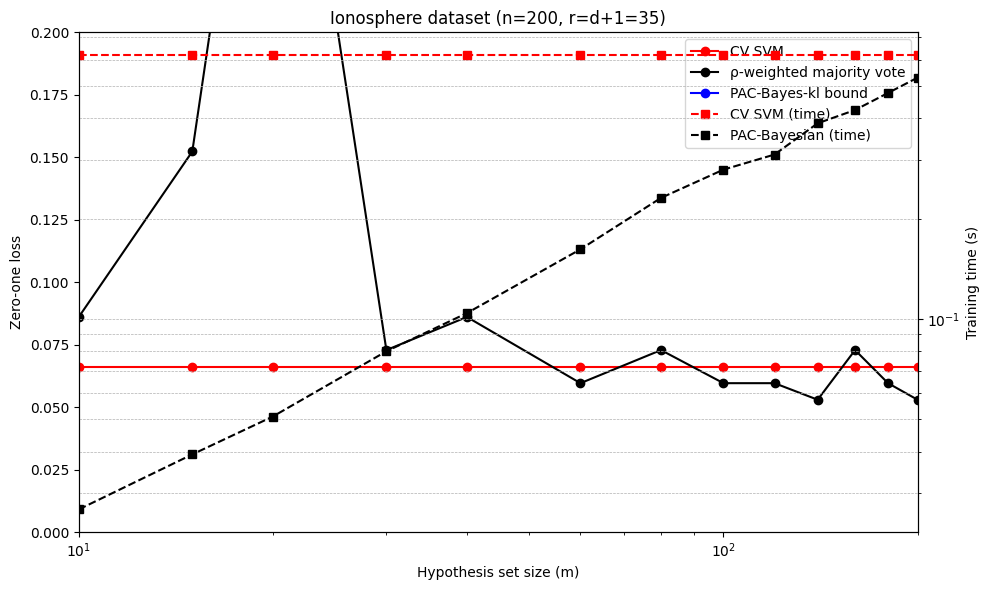

Figure saved as 'ionosphere_figure2a.png'


In [ ]:
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# 1. Load the Ionosphere dataset
print("Loading Ionosphere dataset...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
data = pd.read_csv(urlopen(url), header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
# Convert labels to numerical values
y = np.array([1 if label == "g" else -1 for label in y])

# Splitting the data as in the paper for Ionosphere dataset
# The paper mentions n=200 training and 150 test points
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=150 / 350, random_state=42
)

# Parameters
n = len(X_train)
d = X_train.shape[1]  # Feature dimension
r = d + 1  # Subsample size as specified in the paper (d+1=35)
delta = 0.05  # Confidence parameter
print(f"Dataset info: n={n}, d={d}, r={r}")


# Function to invert KL for bound computation
def binary_kl(p, q):
    if p == 0:
        return -np.log(1 - q)
    if p == 1:
        return -np.log(q)
    return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))


def kl_inverse(p, epsilon, precision=1e-8):
    """Compute q such that kl(p||q) ≤ epsilon using binary search"""
    if p == 0:
        return 0
    if p == 1:
        return 1

    # Binary search for q
    q_min, q_max = p, 1.0
    q = (q_min + q_max) / 2

    while q_max - q_min > precision:
        if binary_kl(p, q) <= epsilon:
            q_max = q
        else:
            q_min = q
        q = (q_min + q_max) / 2

    return q_max


# 2. Baseline: Cross-validated SVM
def train_cv_svm(X_train, y_train, X_test, y_test):
    print("Training cross-validated SVM...")
    start_time = time.time()

    # Use Jaakkola's heuristic for gamma values
    distances = []
    for i in range(min(100, len(X_train))):  # Sample for efficiency
        diff_class_indices = np.where(y_train != y_train[i])[0]
        if len(diff_class_indices) > 0:
            dists = [np.sum((X_train[i] - X_train[j]) ** 2) for j in diff_class_indices]
            if dists:
                distances.append(min(dists))

    gamma_j = 1.0 / (2 * np.median(distances))
    gamma_range = [gamma_j * 10**i for i in range(-4, 5, 2)]
    param_grid = {"C": [10**i for i in range(-3, 4)], "gamma": gamma_range}

    # Use cross-validation to find best parameters
    svm = SVC(kernel="rbf")
    grid_search = GridSearchCV(svm, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Train final model with best parameters
    best_svm = SVC(
        kernel="rbf",
        C=grid_search.best_params_["C"],
        gamma=grid_search.best_params_["gamma"],
    )
    best_svm.fit(X_train, y_train)

    training_time = time.time() - start_time

    # Evaluate on test set
    y_pred = best_svm.predict(X_test)
    test_loss = zero_one_loss(y_test, y_pred)

    print(f"CV SVM - Loss: {test_loss:.4f}, Training Time: {training_time:.2f} s")
    return best_svm, test_loss, training_time, gamma_range


# 3. PAC-Bayesian aggregation
def pac_bayesian_aggregation(
    X_train, y_train, X_test, y_test, m_values, r, gamma_range, delta=0.05
):
    print("Training PAC-Bayesian aggregation for different m values...")
    results = {"test_loss": [], "bound": [], "training_time": []}

    for m in m_values:
        print(f"  Processing m={m}...")
        start_time = time.time()

        # Create m subsamples of size r
        classifiers = []
        validation_losses = []

        for i in range(m):
            # Sample r indices without replacement
            subsample_indices = np.random.choice(n, r, replace=False)
            validation_indices = np.array(
                [i for i in range(n) if i not in subsample_indices]
            )

            # Split into training and validation sets
            X_sub_train = X_train[subsample_indices]
            y_sub_train = y_train[subsample_indices]
            X_sub_val = X_train[validation_indices]
            y_sub_val = y_train[validation_indices]

            # Train SVM on the subsample with randomly selected gamma
            gamma = np.random.choice(gamma_range)
            svm = SVC(kernel="rbf", gamma=gamma)
            svm.fit(X_sub_train, y_sub_train)
            classifiers.append(svm)

            # Compute validation loss
            y_val_pred = svm.predict(X_sub_val)
            val_loss = np.mean(y_val_pred != y_sub_val)
            validation_losses.append(val_loss)

        validation_losses = np.array(validation_losses)

        # Implement alternating minimization
        lambda_val = 0.5  # Initial lambda
        pi = np.ones(m) / m  # Uniform prior
        prev_bound = float("inf")

        for _ in range(100):  # Usually converges quickly
            # Update rho based on equation (7)
            log_numerator = -lambda_val * (n - r) * validation_losses
            log_numerator = log_numerator - np.max(
                log_numerator
            )  # For numerical stability
            numerator = pi * np.exp(log_numerator)
            denominator = np.sum(numerator)
            rho = numerator / denominator

            # Update lambda based on equation (8)
            weighted_val_loss = np.sum(rho * validation_losses)
            kl_term = np.sum(rho * np.log(rho / pi + 1e-10))  # Avoid log(0)
            ln_term = np.log(2 * np.sqrt(n - r) / delta)

            lambda_val = 2 / (
                np.sqrt(2 * (n - r) * weighted_val_loss / (kl_term + ln_term)) + 1 + 1
            )

            # Compute bound for convergence check
            current_bound = weighted_val_loss / (1 - lambda_val / 2) + (
                kl_term + ln_term
            ) / ((n - r) * lambda_val * (1 - lambda_val / 2))
            if abs(current_bound - prev_bound) < 1e-6:
                break
            prev_bound = current_bound

        # Compute weighted majority vote predictions
        y_pred = np.zeros(len(X_test))
        for i, clf in enumerate(classifiers):
            y_pred += rho[i] * clf.predict(X_test)
        y_pred = np.sign(y_pred)

        test_loss = zero_one_loss(y_test, y_pred)

        # Compute PAC-Bayes-kl bound
        weighted_val_loss = np.sum(rho * validation_losses)
        kl_term = np.sum(rho * np.log(rho / pi + 1e-10))
        ln_term = np.log(2 * np.sqrt(n - r) / delta)

        # Use kl_inverse to compute the bound (tighter than the relaxed bound)
        kl_bound = kl_inverse(weighted_val_loss, (kl_term + ln_term) / (n - r))

        training_time = time.time() - start_time

        results["test_loss"].append(test_loss)
        results["bound"].append(kl_bound)
        results["training_time"].append(training_time)

    return results


# 4. Run experiments and plot results
# Define m values to match the non-linear scale in the original Figure 2(a)
# Looking at the figure, the values appear to be logarithmically spaced or specific points
m_values = [10, 15, 20, 30, 40, 60, 80, 100, 120, 140, 160, 180, 200]
print(f"Using m values: {m_values}")

# Train baseline SVM
baseline_svm, baseline_loss, baseline_time, gamma_range = train_cv_svm(
    X_train, y_train, X_test, y_test
)

# Train PAC-Bayesian aggregation for different m values
results = pac_bayesian_aggregation(
    X_train, y_train, X_test, y_test, m_values, r, gamma_range
)

# Create Figure 2(a) as in the paper with dual y-axes
plt.figure(figsize=(10, 6))

# Primary y-axis for loss
ax1 = plt.gca()
ax1.set_xlabel("Hypothesis set size (m)")
ax1.set_ylabel("Zero-one loss")

# Set y-axis limits to match the paper (approximately 0 to 0.2)
ax1.set_ylim(0, 0.2)

# Use log scale for x-axis to match the original figure
ax1.set_xscale("log")
ax1.set_xlim(min(m_values), max(m_values))

# Plot the lines with markers to match the paper
ax1.plot(m_values, [baseline_loss] * len(m_values), "r-", marker="o", label="CV SVM")
ax1.plot(
    m_values, results["test_loss"], "k-", marker="o", label="ρ-weighted majority vote"
)
ax1.plot(m_values, results["bound"], "b-", marker="o", label="PAC-Bayes-kl bound")

# Secondary y-axis for time
ax2 = ax1.twinx()
ax2.set_ylabel("Training time (s)")
ax2.set_yscale("log")  # Use log scale for training time as in the paper

# Plot the time lines with markers to match the paper
ax2.plot(
    m_values, [baseline_time] * len(m_values), "r--", marker="s", label="CV SVM (time)"
)
ax2.plot(
    m_values, results["training_time"], "k--", marker="s", label="PAC-Bayesian (time)"
)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Ionosphere dataset (n=200, r=d+1=35)")
plt.tight_layout()
plt.savefig("ionosphere_figure2a.png", dpi=300)
plt.show()

print("Figure saved as 'ionosphere_figure2a.png'")